In [1]:
import os
import numpy as np 
import pandas as pd
import arviz as az
import pymc3 as pm
import spc_os
import pickle
import seaborn as sns
import cellbell
import matplotlib.pyplot as plt
import sys
import subprocess as sp
sys.path.append("..")
from src.visualization.handle_data import combine_posterior_variables
RANDOM_SEED = 281090

In [2]:
raw_data_dir = '../data/raw/'
interim_data_dir = '../data/interim/'
processed_data_dir = '../data/processed/'
external_data_dir = '../data/external/'
models_dir = '../models/bayesian/'
reports_dir = '../reports/'

In [3]:
%mkdir ../reports/for_print

mkdir: cannot create directory ‘../reports/for_print’: File exists


In [4]:
with open('../data/aa_resid_dic.pkl', 'rb') as my_file:
    aa_dic = pickle.load(my_file)

In [5]:
from spc_imports import *
set_up_plt()

/home/sperez/bin/PYTHON_SCRIPTS/spc_imports.py:21: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams["text.latex.preamble"] = [


# Load MD data

In [6]:
method = 'ppm' # sparta_plus or ppm
nucleus = 'CA' # CA C CB N
data_size = 1000  # 70000 max data_size
model_name = 'skew_model'
infer = False

In [7]:
def load_data_frames(processed_data_dir, method, nucleus, data_size, model_name, RANDOM_SEED):
    df_diff = pd.read_pickle(processed_data_dir + 'diff_CS.pkl')
    mask = df_diff.dropna(axis=1).columns
    df_diff = df_diff.loc[:, mask].xs(nucleus, level='nuclei', axis=1)
    df_exp_o = pd.read_pickle(processed_data_dir + 'open_CS.pkl')

    df_exp_o = df_exp_o.loc[:, mask].xs(nucleus, level='nuclei', axis=1)

    df_3fb5 = pd.read_pickle(processed_data_dir +
                             f'3FB5_lb/CS_{method}_3FB5_lb.pkl')

    df_3fb5 = df_3fb5.loc[:, mask].sample(data_size,
                                          random_state=RANDOM_SEED)
    df_3fb5 = df_3fb5.xs(nucleus, level='nuclei', axis=1)

    df_5vk6 = pd.read_pickle(processed_data_dir +
                             f'5VK6_lb/CS_{method}_5VK6_lb.pkl')

    df_5vk6 = df_5vk6.loc[:, mask].sample(data_size,
                                          random_state=RANDOM_SEED)
    df_5vk6 = df_5vk6.xs(nucleus, level='nuclei', axis=1)

    df_5vkh = pd.read_pickle(processed_data_dir +
                             f'5VKH_lb/CS_{method}_5VKH_lb.pkl')

    df_5vkh = df_5vkh.loc[:, mask].sample(data_size,
                                          random_state=RANDOM_SEED)
    df_5vkh = df_5vkh.xs(nucleus, level='nuclei', axis=1)
    return df_exp_o,df_3fb5, df_5vk6, df_5vkh, df_diff, mask

In [8]:
df_exp_o, df_3fb5, df_5vk6, df_5vkh, df_diff, mask = load_data_frames(processed_data_dir, method, nucleus, data_size, model_name, RANDOM_SEED)

## Make histograms

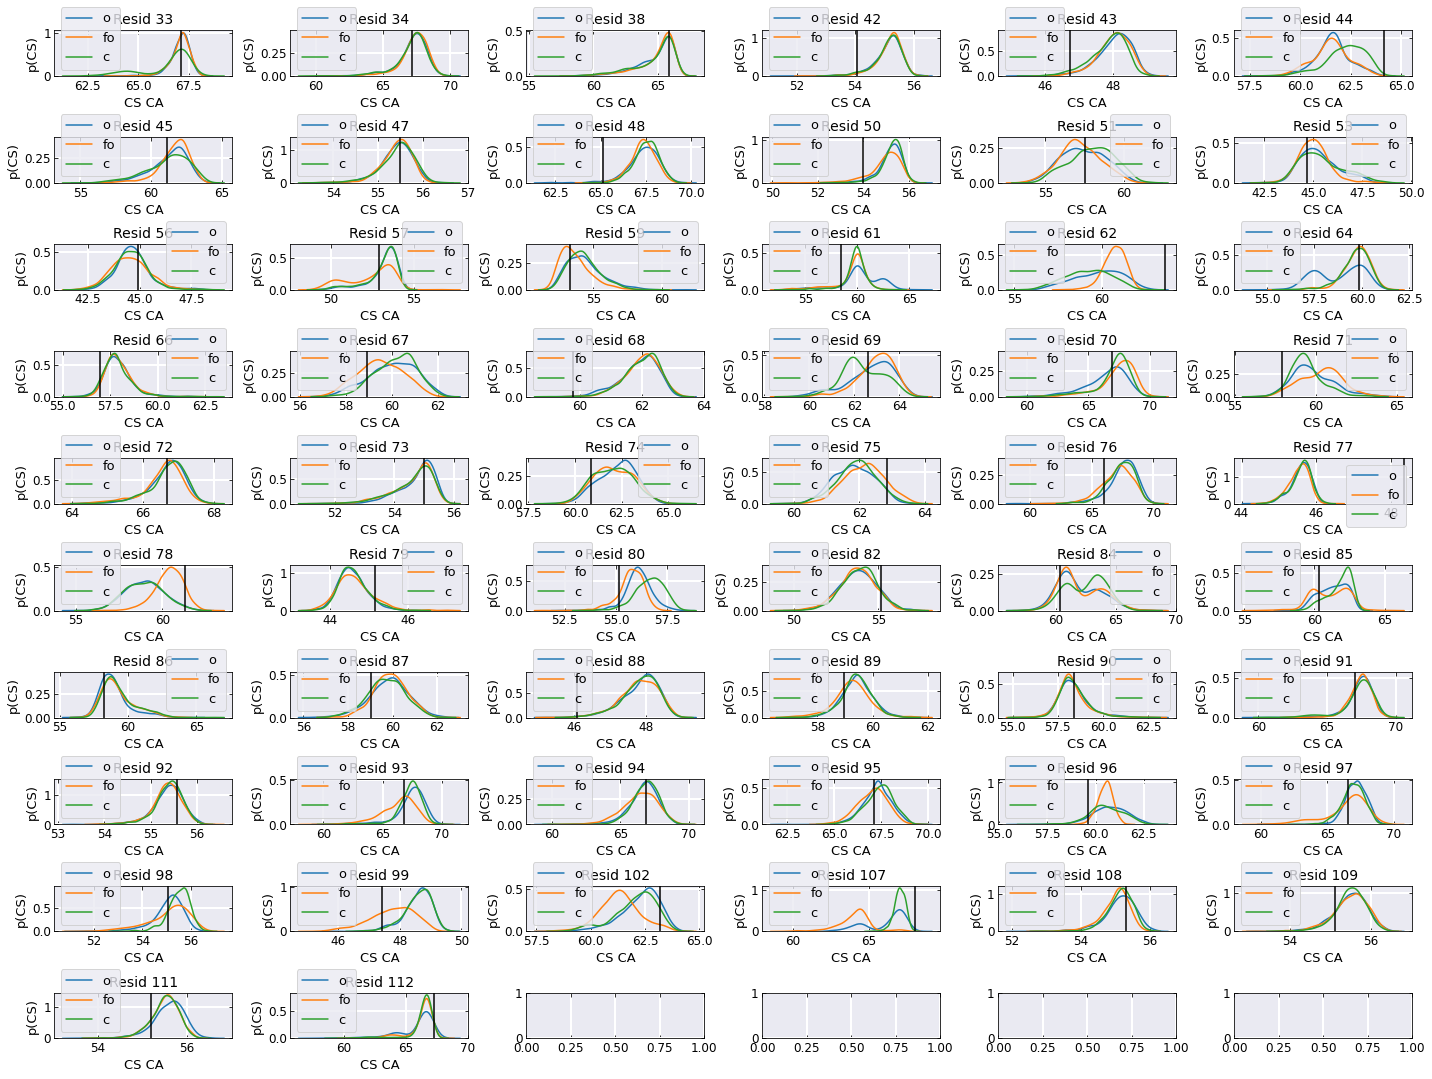

In [9]:
fig, ax = plt.subplots(df_3fb5.shape[1] // 6 + 1, 6, figsize=(20, 15))
ax = ax.flatten()
for i, resid in enumerate(df_3fb5):
    sns.kdeplot(df_3fb5[resid], ax=ax[i], label='o')
    sns.kdeplot(df_5vk6[resid], ax=ax[i], label='fo')
    sns.kdeplot(df_5vkh[resid], ax=ax[i], label='c')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_xlabel(f'CS {nucleus}')
    ax[i].set_ylabel('p(CS)')
    ax[i].axvline(x=df_exp_o[resid][0], c="black")
    ax[i].legend()
fig.tight_layout()
fig.savefig(reports_dir + f'for_print/hist_{method}_{nucleus}.png')

In [10]:
aa_selected = [102]

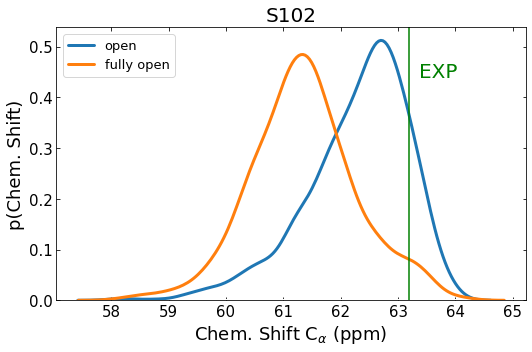

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.))
resid = aa_selected[0]
sns.kdeplot(df_3fb5[resid], ax=ax, label='open', lw=3)
sns.kdeplot(df_5vk6[resid], ax=ax, label='fully open', lw=3)
#sns.kdeplot(df_5vkh[resid], ax=ax, label='closed', lw=3)
ax.set_title(f'{aa_dic[resid]}{resid}',fontsize=20)
ax.set_xlabel(r'Chem. Shift C$_\alpha$ (ppm)',fontsize=18)
ax.set_ylabel('p(Chem. Shift)',fontsize=18)
ax.axvline(x=df_exp_o[resid][0], c="green")
ax.legend(loc='best')
ax.tick_params(labelsize=15)
ax.text(63.7, 0.45, 'EXP', fontsize=20, rotation=0, va='center', ha='center', c='green')
fig.tight_layout()
fig.savefig(reports_dir + f'for_print/hist_{method}_CA_{resid}.png')

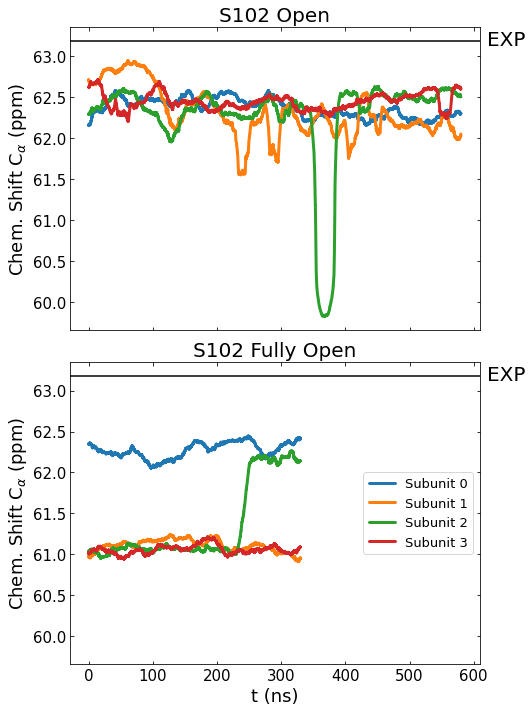

In [71]:
n_roll = 1000
resid = aa_selected[0]
dt= 0.02
fig, ax = plt.subplots(2, 1, figsize=(7.5, 10), sharex=True, sharey=True)
state = '3FB5_lb'
df = pd.read_pickle(f'{processed_data_dir}{state}/CS_{method}_{state}.pkl')
df = df.loc[:, mask].xs(nucleus, level='nuclei', axis=1)
ax = ax.flatten()
for j, split in enumerate(np.split(df[resid], 4)):
    y = split.rolling(n_roll).median()[n_roll:]
    x = dt*np.arange(len(y))
    ax[0].plot(x,y, label=f'Subunit {j}', lw=3)
ax[0].axhline(y=df_exp_o[resid][0], c="black")
ax[0].text(650,63.2, 'EXP', fontsize=20, rotation=0, va='center', ha='center', c='black')
ax[0].set_title(f'{aa_dic[resid]}{resid} Open',fontsize=20)
ax[0].set_ylabel(r'Chem. Shift C$_\alpha$ (ppm)',fontsize=18)
ax[0].tick_params(labelsize=15)
state = '5VK6_lb'
df = pd.read_pickle(f'{processed_data_dir}{state}/CS_{method}_{state}.pkl')
df = df.loc[:, mask].xs(nucleus, level='nuclei', axis=1)
ax = ax.flatten()
for j, split in enumerate(np.split(df[resid], 4)):
    y = split.rolling(n_roll).median()[n_roll:]
    x = dt*np.arange(len(y))
    ax[1].plot(x,y, label=f'Subunit {j}', lw=3)
ax[1].axhline(y=df_exp_o[resid][0], c="black")
ax[1].text(650,63.2, 'EXP', fontsize=20, rotation=0, va='center', ha='center', c='black')
ax[1].set_title(f'{aa_dic[resid]}{resid} Fully Open',fontsize=20)
ax[1].set_ylabel(r'Chem. Shift C$_\alpha$ (ppm)',fontsize=18)
ax[1].set_xlabel('t (ns)',fontsize=18)
ax[1].tick_params(labelsize=15)
ax[1].legend(loc='center right')


fig.tight_layout()
fig.savefig(reports_dir + f'for_print/time_series_{method}_{nucleus}_{resid}.png')
del df

# Study Inference

## Load Data 

In [9]:
methods = {}

In [10]:
nuclei = ['CA','CB','C','N']

In [11]:
for nucleus in nuclei:
    methods[nucleus] = {}
    for method in ['ppm','sparta_plus']:
        model_path = models_dir + f"{model_name}_{method}_{nucleus}.nc"
        my_model = az.from_netcdf(model_path)
        my_model.posterior = combine_posterior_variables(
        my_model.posterior, ['mean_o_c', 'mean_fo_c'], 'delta_delta', 'state',
        ['Open', 'Fully Open'])
        methods[nucleus][method]= { 'data': my_model}

In [12]:
methods['CA']['ppm']['aa'] = ['Y62', 'R64', 'Y78', 'G99', 'S102', 'T107']
methods['CB']['ppm']['aa'] = ['E51', 'Y62', 'Y78', 'M96', 'A98', 'S102', 'A111']
methods['C']['ppm']['aa'] = ['Y62', 'Y78']
methods['N']['ppm']['aa'] = ['L59', 'Y78', 'M96', 'I100', 'S102', 'F103', 'A108']

In [13]:
methods['CA']['sparta_plus']['aa'] = ['A50', 'T61', 'R64', 'T75', 'S102', 'T107']
methods['CB']['sparta_plus']['aa'] = [ 'I60', 'T61', 'Y62']
methods['C']['sparta_plus']['aa'] = []
methods['N']['sparta_plus']['aa'] = ['L59', 'M96', 'G99', 'I100', 'S102', 'F103']

In [ ]:
methods['CA']['shiftx2']['aa'] =
methods['CB']['shiftx2']['aa'] =
methods['C']['shiftx2']['aa'] =
methods['N']['shiftx2']['aa'] =

In [14]:
plt.rcParams["text.usetex"] = False

In [15]:
plt.rcParams["axes.facecolor"] = "white" #"#EAEAF2"

## Statical filtering

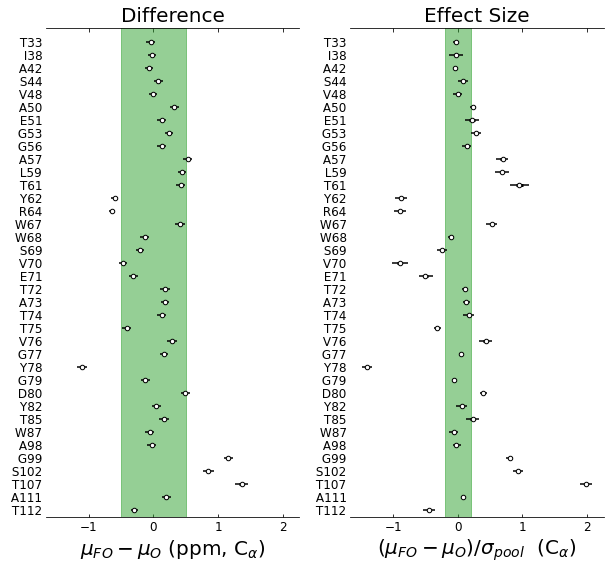

In [223]:
method = 'ppm'
nucleus = 'CA'
my_model = methods[nucleus][method]['data']
fig, ax = plt.subplots(1,2, figsize=(10,9), sharex=True)
az.plot_forest(my_model.posterior.rename({'effect_size':''})[''], combined=True, var_names=[''], rope=(-0.5, 0.5), colors='black', ax=ax[0])
az.plot_forest(my_model.posterior.rename({'diff_means':''})[''], rope=(-0.2, 0.2), combined=True,
              var_names=[''], colors='black', ax=ax[1])
ax[0].set_xlabel(r'$\mu_{FO}-\mu_{O}$ (ppm, C$_\alpha$)', size=20)
ax[0].set_title('Difference', size=20)
ax[1].set_xlabel(r'$(\mu_{FO}-\mu_{O})/\sigma_{pool}$  $(\mathrm{C}_\alpha)$',size=20)
ax[1].set_title('Effect Size', size=20)
plt.savefig(f'{reports_dir}for_print/statistical_filtering_{model_name}_{method}_{nucleus}.svg')
plt.savefig(f'{reports_dir}for_print/statistical_filtering_{model_name}_{method}_{nucleus}.png')

## Markers

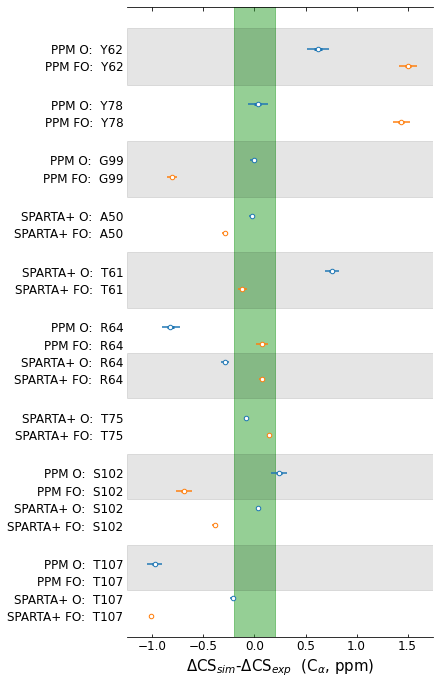

In [228]:
nucleus = 'CA'
my_model = methods[nucleus]
az.plot_forest(
    (my_model['ppm']['data'].posterior.sel(state="Open").rename({'delta_delta':''})[''],
    my_model['ppm']['data'].posterior.sel(state="Fully Open").rename({'delta_delta':''})[''],
    my_model['sparta_plus']['data'].posterior.sel(state="Open").rename({'delta_delta':''})[''],
    my_model['sparta_plus']['data'].posterior.sel(state="Fully Open").rename({'delta_delta':''})['']
    ),
    #var_names=["","","",""],
    combined=True,
    colors=["C0", "C1","C0","C1"],
    model_names=["PPM O", "PPM FO", "SPARTA+ O", "SPARTA+ FO"],
    rope=(-0.2, 0.2),
    coords=({'resid': my_model['ppm']['aa']},
           {'resid': my_model['ppm']['aa']},
            {'resid': my_model['sparta_plus']['aa']},
            {'resid': my_model['sparta_plus']['aa']}
           )
)
plt.xlabel(r'$\Delta$CS$_{sim}$-$\Delta$CS$_{exp}$  (C$_\alpha$, ppm)',size=15)
plt.title('')
plt.xlim([-1.25,1.75])
plt.savefig(f'{reports_dir}for_print/assignment_{model_name}_all_{nucleus}_print.svg')
plt.savefig(f'{reports_dir}for_print/assignment_{model_name}_all_{nucleus}_print.png')

## Correlation plots

In [112]:
nuclei_to_latex = {
    'CA': r'C$_\alpha$',
    'CB': r'C$_\beta$',
    'N': r'N',
    'C': r'C',
}

In [177]:
method_to_latex = {
'sparta_plus': 'SPARTA+',
    'ppm': 'PPM',
    'shiftx2': 'SHIFTX2'
}

In [111]:
df = pd.DataFrame()
for method in ['ppm', 'sparta_plus']:
    for nucleus in nuclei[:]:
        df_exp_o, df_3fb5, df_5vk6, df_5vkh, df_diff, mask = load_data_frames(processed_data_dir, method, nucleus, data_size, model_name, RANDOM_SEED)
        df0 = pd.DataFrame()
        sim=az.summary(methods[nucleus][method]['data'])
        sim = (sim['hdi_97%'] + sim['hdi_3%'])/2.
        sim = sim.filter(axis=0,regex='delta_delta')
        df0[r'$\Delta$CS$_{sim}$'] = sim
        df0.index = list(methods[nucleus][method]['data'].posterior.resid.to_series())*2
        df0 = df0.drop('W113', errors='ignore')
        resnum = [ int(res[1:]) for res in df0.index]
        df0[r'$\Delta$CS$_{exp}$'] = df_diff.T.loc[resnum].to_numpy()
        df0['State'] = 'Open'
        df0['State'][df0.shape[0]//2+1:] = 'Fully-Open'
        df0['method'] = method
        df0['Nucleus'] = nucleus
        df['Nucleus'] = df['Nucleus'].transform(lambda x: nuclei_to_latex[x])
        df = pd.concat([df, df0])

<ipython-input-111-b88bc416f716>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['State'][df0.shape[0]//2+1:] = 'Fully-Open'
/home/sperez/data_partition/bin2/anaconda3/envs/nmr_assign_state/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-111-b88bc416f716>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['State'][d

/home/sperez/data_partition/bin2/anaconda3/envs/nmr_assign_state/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


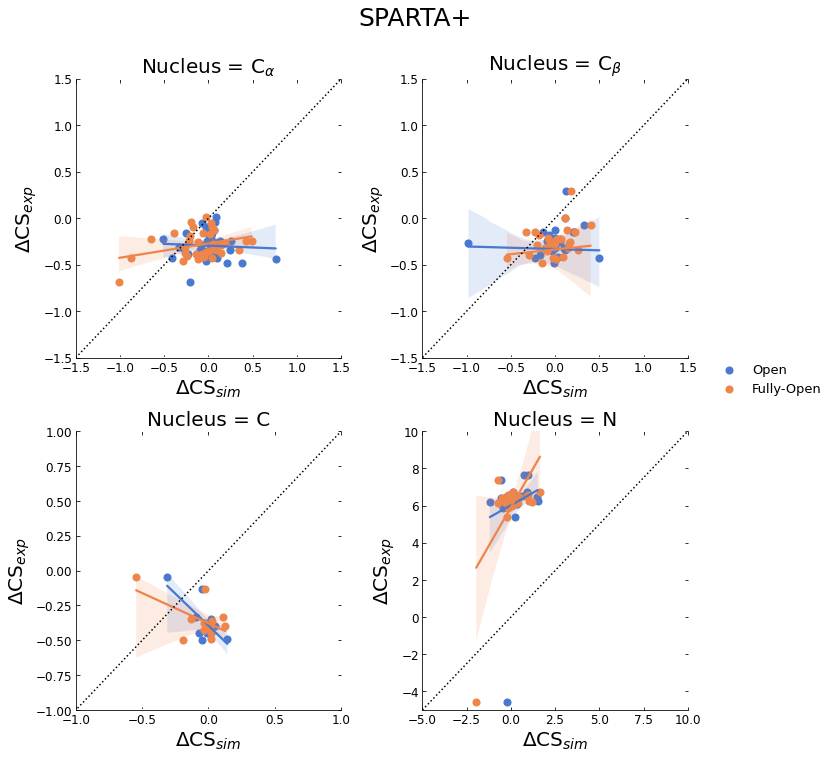

In [180]:
method = 'sparta_plus'
g = sns.lmplot(x=r'$\Delta$CS$_{sim}$', y=r'$\Delta$CS$_{exp}$', col="Nucleus", hue="State", data=df[df.method == method],
           col_wrap=2, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1}
           ,sharex=False,sharey=False, size = 5
              )
ax = g.axes
ax[0].set_ylim([-1.5,1.5])
ax[0].set_xlim([-1.5,1.5])
ax[1].set_ylim([-1.5,1.5])
ax[1].set_xlim([-1.5,1.5])
ax[2].set_ylim([-1.,1.])
ax[2].set_xlim([-1.,1.])
ax[3].set_ylim([-5,10])
ax[3].set_xlim([-5,10])
for a in ax:
    a.plot(np.arange(-5,30,10),np.arange(-5,30,10), color='k', ls = ':')
    a.set_xlabel(r'$\Delta$CS$_{sim}$', size=20)
    a.set_ylabel(r'$\Delta$CS$_{exp}$', size=20)
    a.title.set_size(20)
g.tight_layout()
g.legend.set_title("")
g.fig.suptitle(method_to_latex[method], y=1.05, size = 25)
plt.savefig(f'{reports_dir}for_print/correlation_{method}_print.png')

/home/sperez/data_partition/bin2/anaconda3/envs/nmr_assign_state/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


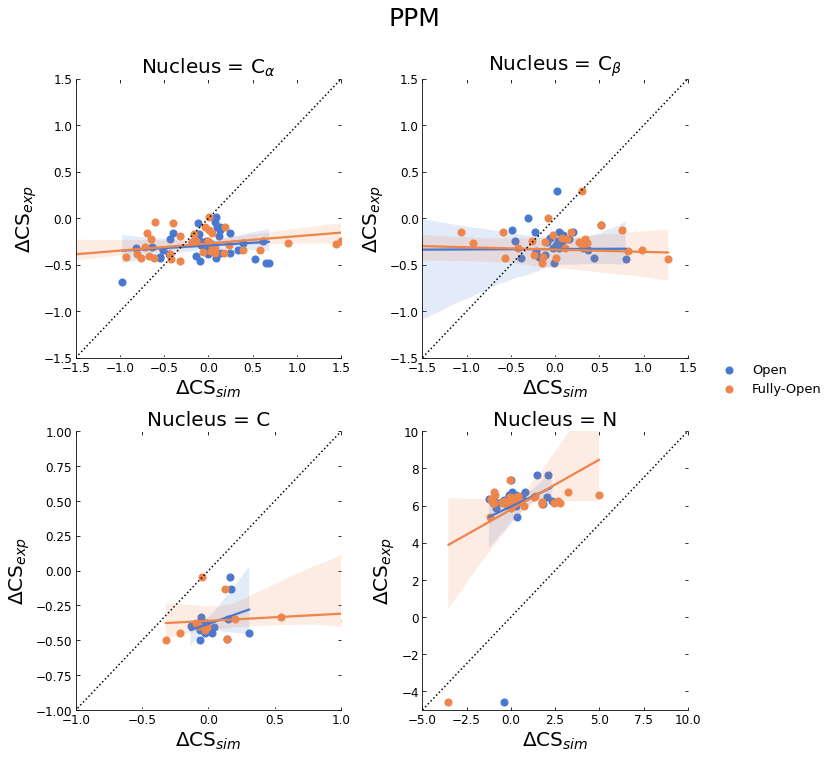

In [181]:
method = 'ppm'
g = sns.lmplot(x=r'$\Delta$CS$_{sim}$', y=r'$\Delta$CS$_{exp}$', col="Nucleus", hue="State", data=df[df.method == method],
           col_wrap=2, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1}
           ,sharex=False,sharey=False, size = 5
              )
ax = g.axes
ax[0].set_ylim([-1.5,1.5])
ax[0].set_xlim([-1.5,1.5])
ax[1].set_ylim([-1.5,1.5])
ax[1].set_xlim([-1.5,1.5])
ax[2].set_ylim([-1.,1.])
ax[2].set_xlim([-1.,1.])
ax[3].set_ylim([-5,10])
ax[3].set_xlim([-5,10])
for a in ax:
    a.plot(np.arange(-5,30,10),np.arange(-5,30,10), color='k', ls = ':')
    a.set_xlabel(r'$\Delta$CS$_{sim}$', size=20)
    a.set_ylabel(r'$\Delta$CS$_{exp}$', size=20)
    a.title.set_size(20)
g.tight_layout()
g.legend.set_title("")
g.fig.suptitle(method_to_latex[method], y=1.05, size = 25)
plt.savefig(f'{reports_dir}for_print/correlation_{method}_print.png')

/home/sperez/data_partition/bin2/anaconda3/envs/nmr_assign_state/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


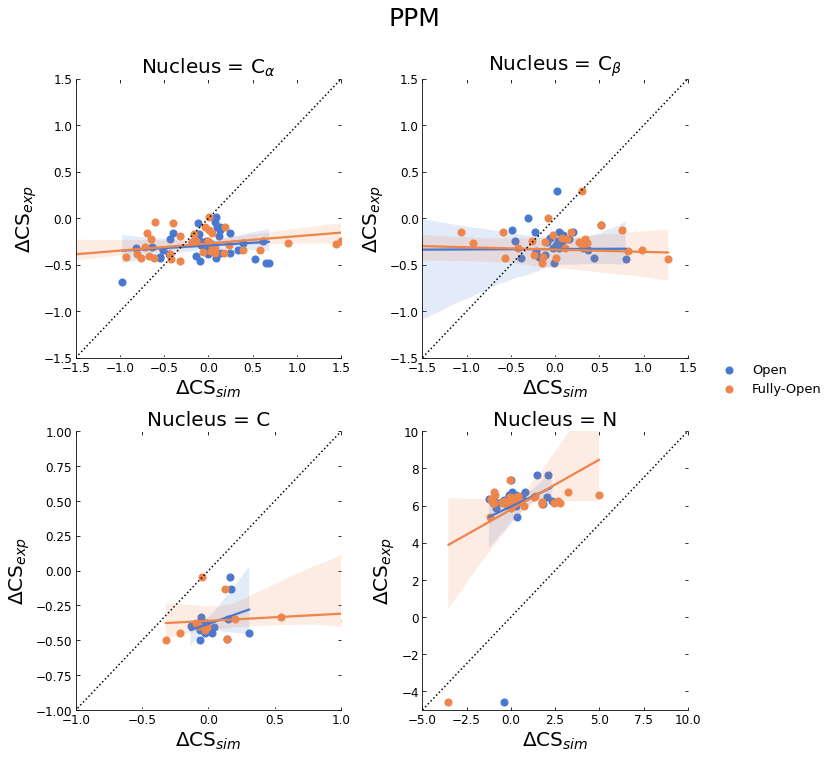

In [181]:
method = 'shiftx2'
g = sns.lmplot(x=r'$\Delta$CS$_{sim}$', y=r'$\Delta$CS$_{exp}$', col="Nucleus", hue="State", data=df[df.method == method],
           col_wrap=2, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1}
           ,sharex=False,sharey=False, size = 5
              )
ax = g.axes
ax[0].set_ylim([-1.5,1.5])
ax[0].set_xlim([-1.5,1.5])
ax[1].set_ylim([-1.5,1.5])
ax[1].set_xlim([-1.5,1.5])
ax[2].set_ylim([-1.,1.])
ax[2].set_xlim([-1.,1.])
ax[3].set_ylim([-5,10])
ax[3].set_xlim([-5,10])
for a in ax:
    a.plot(np.arange(-5,30,10),np.arange(-5,30,10), color='k', ls = ':')
    a.set_xlabel(r'$\Delta$CS$_{sim}$', size=20)
    a.set_ylabel(r'$\Delta$CS$_{exp}$', size=20)
    a.title.set_size(20)
g.tight_layout()
g.legend.set_title("")
g.fig.suptitle(method_to_latex[method], y=1.05, size = 25)
plt.savefig(f'{reports_dir}for_print/correlation_{method}_print.png')

# Study the Simulations

## Occupation of SF

In [31]:
states = { 
    '3FB5_lb' : {'begin': 400000.,
                      'end': 1000000.,
                'title': 'Open'},
          '5VK6_lb': {'begin': 0.,
                      'end': 350000.,
                'title': 'Fully-Open'},
          '5VKH_lb': {'begin': 0,
                      'end': 1.e+20,
                'title': 'Closed'}
         }

In [21]:
%cd /data/sperez/Projects/nmr_assign_state/notebooks/

/data/sperez/Projects/nmr_assign_state/notebooks


This cell calls the program of Kopec et al. from (https://doi.org/10.1038/s41467-019-13227-w) freely available in the supplementary data.

In [22]:
cdminus = os.getcwd()
for state in states.keys():
    print(state)
    spc_os.mkdir(processed_data_dir+state+'/SF_occupation')
    os.chdir(processed_data_dir+state+'/SF_occupation')
    myoutput = open("stdout",'w+')
    sp.run(f"../../../../../KcsA/Scripts/KopecProgram/xtck ../../../interim/{state}/all_pbc.gro ../../../interim/{state}/all_sk1_pbc.xtc",check=True,shell=True,stdout=myoutput)
    myoutput.close()
    os.chdir(cdminus)

3FB5_lb
5VK6_lb
5VKH_lb
5VKE_lb


In [60]:
def get_occupation(state):
    occupation = []
    occupation_labels = ['W', 'K', '0' ]
    
    sites = ['S0', 'S1', 'S2', 'S3', 'S4', 'S5']
    with open(processed_data_dir+state+'/SF_occupation/stdout') as file:
        file = file.readlines()[23:-3]
        for line in file:
            occupation_split =[]
            for site in line.split()[4]:
                occupation_split.append(site)
            occupation.append(occupation_split)
    occupation = pd.DataFrame(occupation, columns=sites)
    for i, label in enumerate(occupation_labels):
        occupation[ occupation == label ] = i
    occupation = occupation.astype(int)
    return occupation, occupation_labels, sites

<ipython-input-78-8e01cd33416d>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  k.append( ax[i].pcolor(np.array(time),np.arange(len(sites)+1),occupation.T,cmap=plt.cm.get_cmap("tab20c", len(occupation_labels))))


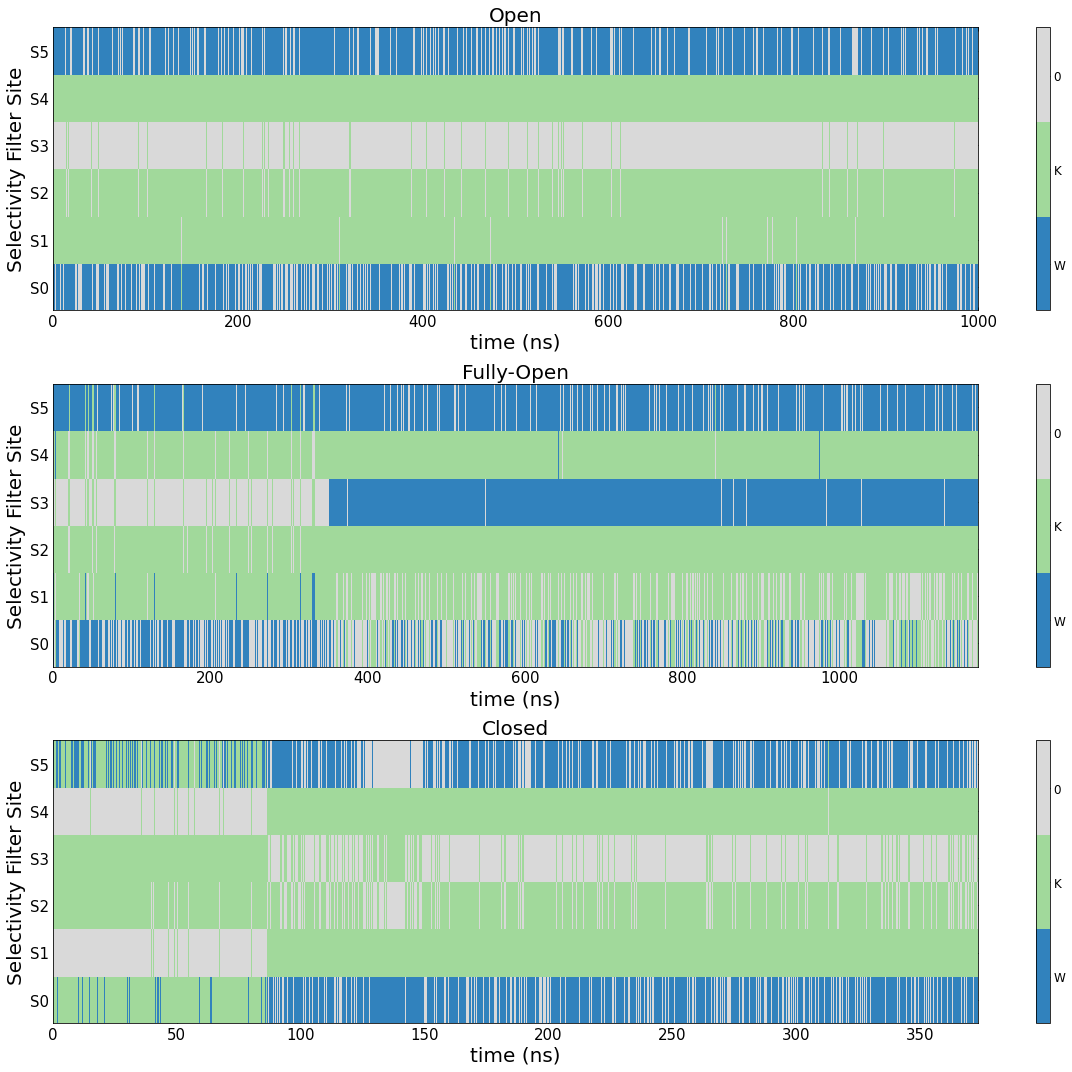

In [78]:
fig, ax = plt.subplots(3, 1,figsize = (17, 5*3))
k = []
occupation_labels_colorbar ={
        0.33 : 'W',
        1 : 'K',
        1.66: '0'
    }
for i, state in enumerate(states.keys()):
    occupation, occupation_labels, sites = get_occupation(state)
    time = occupation.index * 0.02
    k.append( ax[i].pcolor(np.array(time),np.arange(len(sites)+1),occupation.T,cmap=plt.cm.get_cmap("tab20c", len(occupation_labels))))
    formatter = plt.FuncFormatter(lambda val, loc: occupation_labels_colorbar[val])
    ax[i].set_xlabel('time (ns)', size=20)
    ax[i].set_ylabel('Selectivity Filter Site', size=20)
    ax[i].set_yticks(np.arange(len(sites))+0.5)
    ax[i].set_yticklabels([ f'S{j}' for j in np.arange(len(sites))])
    ax[i].tick_params(labelsize=15)
    title =states[state]['title']
    ax[i].set_title(title, size=20)
    plt.colorbar(k[i], ax=ax[i], ticks=[0.33,1,1.66],format=formatter)
fig.tight_layout()
plt.savefig(f'{reports_dir}for_print/SF_occupation_print.svg')
plt.savefig(f'{reports_dir}for_print/SF_occupation_print.png')